In [1]:
from ase.build import bulk

from dask.distributed import Client
from dask_cuda import LocalCUDACluster

from abtem import FrozenPhonons, Probe, Potential, GridScan, AnnularDetector

import os
os.environ["MKL_NUM_THREADS"] = "1"

from abtem import config
config.set({'device': 'gpu'})
config.set({'dask.lazy': True})

Runtime: 2.6 s per frozen phonon on 1 NVidia RTX 2080 Ti

In [2]:
cluster = LocalCUDACluster(memory_limit='10gb', n_workers=1)
client = Client(cluster)

C:\Users\jacob\anaconda3\envs\dask-gpu\lib\site-packages\distributed\node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 55449 instead
  warnings.warn(
C:\Users\jacob\anaconda3\envs\dask-gpu\lib\site-packages\dask_cuda\utils.py:214: UserWarning: Cannot get CPU affinity for device with index 0, setting default affinity
  warnings.warn(


In [3]:
atoms = bulk('Si', 'diamond', a=5.43, cubic=True)
atoms *= (2, 2, 20)

In [5]:
chunks = 300

frozen_phonons = FrozenPhonons(atoms, 8, {'Si': .1})

potential = Potential(frozen_phonons, gpts=512, projection='infinite', slice_thickness=2)

probe = Probe(energy=100e3, semiangle_cutoff=20)

scan = GridScan()

detectors = AnnularDetector(50, 150)

measurement = probe.scan(potential, scan, detectors, chunks=chunks)

In [6]:
probe.build(scan, chunks).array # For showing the size of the chunks

dask.array<_calculate_array, shape=(27, 27, 512, 512), dtype=complex64, chunksize=(14, 14, 512, 512), chunktype=cupy.ndarray>

In [7]:
%%time
measurement.compute()

Wall time: 32.3 s


(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x217e36a5f70>)

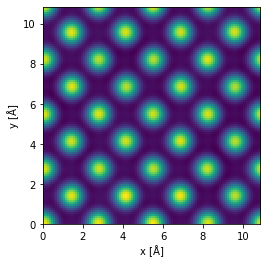

In [8]:
measurement.interpolate(.1).show()